In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn import model_selection
from sklearn import metrics
import time
import tensorflow as tf
import shap
import numpy as np

In [2]:
#read kdd_processed.csv
df = pd.read_csv('kdd_processed_bin_lime.csv')
# get the names of the columns in a list
columns = df.columns.tolist()

In [3]:
#read kdd_processed_bin_top15.csv
df_bin = pd.read_csv('kdd_processed_bin_top15.csv')

# get the names of the columns in a list
columns_bin = df_bin.columns.tolist()

In [4]:
print(columns)
print(columns_bin)

['num_compromised', 'wrong_fragment', 'num_root', 'num_failed_logins', 'hot', 'root_shell', 'num_access_files', 'dst_host_rerror_rate', 'logged_in', 'rerror_rate', 'num_file_creations', 'su_attempted', 'srv_rerror_rate', 'flag', 'num_shells', 'class']
['service', 'serror_rate', 'dst_host_count', 'protocol_type', 'dst_host_rerror_rate', 'same_srv_rate', 'dst_host_srv_count', 'count', 'dst_host_same_src_port_rate', 'dst_host_serror_rate', 'logged_in', 'flag', 'dst_host_same_srv_rate', 'srv_serror_rate', 'dst_host_srv_serror_rate', 'class']


In [5]:
#combine the two lists of columns without duplicates
columns = list(set(columns + columns_bin))
print(columns)
#print length of columns
print(len(columns))

['root_shell', 'su_attempted', 'serror_rate', 'count', 'rerror_rate', 'dst_host_serror_rate', 'num_access_files', 'srv_serror_rate', 'num_file_creations', 'num_failed_logins', 'dst_host_srv_serror_rate', 'dst_host_count', 'dst_host_same_srv_rate', 'dst_host_srv_count', 'dst_host_rerror_rate', 'num_root', 'service', 'hot', 'num_shells', 'num_compromised', 'class', 'flag', 'same_srv_rate', 'dst_host_same_src_port_rate', 'logged_in', 'srv_rerror_rate', 'wrong_fragment', 'protocol_type']
28


In [6]:
data = pd.read_csv('kdd_processed_bin.csv')

In [7]:
#drop all columns that are not in the list
data = data.drop(data.columns.difference(columns), axis=1)

In [8]:
data

,protocol_type,service,flag,wrong_fragment,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,...,srv_rerror_rate,same_srv_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_same_src_port_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,class
0,0,20,9,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,2.274677,1.512002,0.225830,0.378662,0.550167,0.000000,0.000000,0.163102,0
1,1,44,9,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.181974,2.570404,0.009033,0.000000,2.847923,0.000000,0.000000,0.000000,0
2,0,49,5,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.113734,2.570404,0.234863,0.222742,0.000000,2.248282,2.243817,0.000000,1
3,0,24,9,0.0,0.0,0.0,1,0.0,0.0,0.0,...,0.0,2.274677,0.302400,2.303466,2.227423,0.097088,0.067448,0.022438,0.000000,0
4,0,24,9,0.0,0.0,0.0,1,0.0,0.0,0.0,...,0.0,2.274677,2.570404,2.303466,2.227423,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,49,5,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.318455,2.570404,0.225830,0.222742,0.000000,2.248282,2.243817,0.000000,1
125969,1,49,9,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,2.274677,2.570404,2.204101,2.138326,0.032363,0.000000,0.000000,0.000000,0
125970,0,54,9,0.0,0.0,0.0,1,0.0,0.0,0.0,...,0.0,2.274677,2.570404,0.270996,0.267291,0.000000,1.618763,0.000000,0.032620,0
125971,0,30,5,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.136481,2.570404,0.072266,0.066823,0.000000,2.248282,2.243817,0.000000,1


In [9]:
# train an lstm model on the data
X = data.drop('class', axis=1)
Y = data['class']
# one hot encode Y
# Y = pd.get_dummies(Y)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

# convert Y to int
Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)

# reshape the data for LSTM
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# convert all to numpy arrays
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)

# define the model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# train the model
start = time.time()
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test), shuffle=True)
end = time.time()
print("Time taken to train the model: ", end-start)

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9454 - loss: 0.1445 - val_accuracy: 0.9787 - val_loss: 0.0557
Epoch 2/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9818 - loss: 0.0486 - val_accuracy: 0.9847 - val_loss: 0.0433
Epoch 3/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9865 - loss: 0.0392 - val_accuracy: 0.9891 - val_loss: 0.0350
Epoch 4/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9887 - loss: 0.0330 - val_accuracy: 0.9899 - val_loss: 0.0315
Epoch 5/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9894 - loss: 0.0309 - val_accuracy: 0.9887 - val_loss: 0.0378
Epoch 6/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9896 - loss: 0.0290 - val_accuracy: 0.9880 - val_loss: 0.0387
Epoch 7/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9906 - loss: 0.0261 - val_accuracy: 0.9904 - val_loss: 0.0289
Epoch 8/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9907 - loss: 0.0266 -

5-FOLD CROSS VALIDATION

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)
X = data.drop('class', axis=1)
Y = data['class']

# reshape the data for LSTM
X_fit = X.values.reshape((X.shape[0], 1, X.shape[1]))
X_fit = np.asarray(X_fit).astype(np.float32)

# define the model
model = Sequential()
model.add(LSTM(64, input_shape=(X_fit.shape[1], X_fit.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')


accuracies = []

for train_idx, test_idx in kfold.split(X_fit):
    model.fit(X_fit[train_idx], Y[train_idx], epochs=10, batch_size=32, verbose=0)
    accuracy = model.evaluate(X_fit[test_idx], Y[test_idx], verbose=0)[1]
    accuracies.append(accuracy)

print(accuracies)
#mean accuracy
print("Mean- ",np.mean(accuracies))

[0.9928160309791565, 0.9937686324119568, 0.9944036602973938, 0.9953163266181946, 0.996745228767395]
0.9946099758148194
Mean-  0.9946099758148194


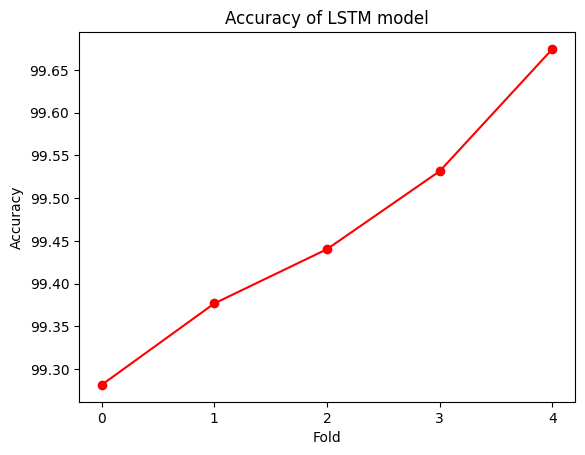

In [7]:
#[0.9928160309791565, 0.9937686324119568, 0.9944036602973938, 0.9953163266181946, 0.996745228767395] put in a list
list = [0.9928160309791565, 0.9937686324119568, 0.9944036602973938, 0.9953163266181946, 0.996745228767395]
# times 100 the list
list = [i * 100 for i in list]
# plot the list 
import numpy as np
import matplotlib.pyplot as plt
#make the plot such that each fold accuracy is circled but also connected by a line
plt.plot(list, 'ro-')
plt.ylabel('Accuracy')
# x label should only be whole numbers
plt.xticks(np.arange(0, 5, 1))
plt.xlabel('Fold')
plt.title('Accuracy of LSTM model')
plt.show()


In [ ]:
start_time = time.time()
y_pred = model.predict(X_test)
end_time = time.time()
y_pred = (y_pred > 0.5)
print('Classification Report')
print(metrics.classification_report(Y_test, y_pred,digits=4))
print('Accuracy:')
print(metrics.accuracy_score(Y_test, y_pred))
print('Time taken to predict: ', end_time-start_time)

788/788 [==============================] - 1s 570us/step
Classification Report
              precision    recall  f1-score   support

           0     0.9911    0.9931    0.9921     13422
           1     0.9922    0.9898    0.9910     11773

    accuracy                         0.9916     25195
   macro avg     0.9916    0.9915    0.9915     25195
weighted avg     0.9916    0.9916    0.9916     25195

Accuracy:
0.9915856320698552
Time taken to predict:  1.033681869506836
